In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random as rnd
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from IPython.display import Image 
from StringIO import StringIO
import pydotplus
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [6]:
train_df, test_df = titanic("./train.csv", "./test.csv")

In [7]:
train_df = pd.get_dummies(train_df, ["Embarked"])

test_df = pd.get_dummies(test_df, ['Embarked'])

In [8]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22,1,0,7.2500,1,2,0,0,0,1
1,1,1,1,38,1,0,71.2833,3,2,0,1,0,0
2,1,3,1,26,0,0,7.9250,2,1,1,0,0,1
3,1,1,1,35,1,0,53.1000,3,2,0,0,0,1
4,0,3,0,35,0,0,8.0500,1,1,1,0,0,1


In [9]:
x_train = train_df.iloc[:713,1:]
y_train = train_df.iloc[:713,0]
x_test = train_df.iloc[713:,1:]
y_test = train_df.iloc[713:,0]

In [11]:
@timeit
def hyperparameters(model, parameters, train, test):
    acc_scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, parameters, scoring = acc_scorer)
    return grid_search.fit(train, test)

In [24]:
clf = RandomForestClassifier(random_state = 84)

parameters = {'n_estimators': [32, 128], 
              'max_features': ['log2', 'auto', None], 
              'criterion': ['gini'],
              'max_depth': [5, 8], 
              'min_samples_split': [8, 16],
              'min_samples_leaf': [10, 16]
             }

grid_search = hyperparameters(clf, parameters, x_train, y_train)
clf = grid_search.best_estimator_
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
accuracy_score(y_test, prediction)

'hyperparameters'  38859.18 ms


0.848314606741573

In [20]:
@timeit
def cv_plot(grid):
    train_score = grid.cv_results_['mean_train_score']
    test_score = grid.cv_results_['mean_test_score']
    X = pd.DataFrame(grid.cv_results_).iloc[:,4]
    plt.plot(X, train_score, c = 'r')
    plt.plot(X, test_score, c = 'b')
    plt.legend()
    plt.show()

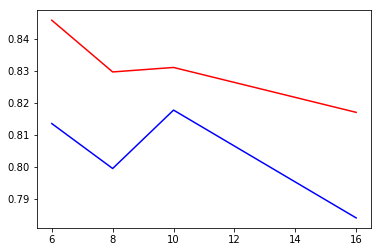

'cv_plot'  159.35 ms


In [23]:
cv_plot(grid_search)

In [155]:
# df = pd.DataFrame(np.array([test_df['PassengerId'], prediction]).T,columns = ['PassengerId', 'Survived'])

# df.to_csv("randomforest_prediction.csv", index = False)

In [164]:
# prediction = clf.predict(test_df.iloc[:, 1:])

In [15]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.095492,0.016669,0.814867,0.838701,gini,5,log2,6,8,32,...,0.810924,0.848421,0.831933,0.816842,0.801688,0.850840,0.029089,0.000790,0.012655,0.015488
1,0.285501,0.062256,0.820477,0.844314,gini,5,log2,6,8,128,...,0.819328,0.852632,0.831933,0.827368,0.810127,0.852941,0.003167,0.000468,0.008936,0.011983
2,0.073457,0.016503,0.807854,0.843612,gini,5,log2,6,16,32,...,0.798319,0.848421,0.831933,0.829474,0.793249,0.852941,0.001901,0.000496,0.017169,0.010166
3,0.295508,0.064791,0.816269,0.839409,gini,5,log2,6,16,128,...,0.806723,0.850526,0.831933,0.825263,0.810127,0.842437,0.009686,0.001550,0.011174,0.010534
4,0.073112,0.016578,0.816269,0.838002,gini,5,log2,8,8,32,...,0.810924,0.848421,0.831933,0.818947,0.805907,0.846639,0.000258,0.000519,0.011275,0.013494
5,0.299366,0.071550,0.819074,0.838701,gini,5,log2,8,8,128,...,0.815126,0.846316,0.831933,0.818947,0.810127,0.850840,0.015071,0.008727,0.009328,0.014090
6,0.075268,0.016497,0.814867,0.829587,gini,5,log2,8,16,32,...,0.815126,0.837895,0.831933,0.812632,0.797468,0.838235,0.000646,0.000404,0.014066,0.011990
7,0.303213,0.067942,0.813464,0.840105,gini,5,log2,8,16,128,...,0.806723,0.844211,0.831933,0.825263,0.801688,0.850840,0.016500,0.006434,0.013233,0.010838
8,0.072713,0.016176,0.812062,0.837302,gini,5,auto,6,8,32,...,0.802521,0.844211,0.840336,0.823158,0.793249,0.844538,0.000961,0.000289,0.020369,0.010002
9,0.286477,0.062285,0.813464,0.840805,gini,5,auto,6,8,128,...,0.810924,0.844211,0.831933,0.825263,0.797468,0.852941,0.002098,0.000609,0.014180,0.011553


In [4]:
def timeit(method):

    def timed(*args, **kw):

        ts = time.time()

        result = method(*args, **kw)

        te = time.time()

        if 'log_time' in kw:

            name = kw.get('log_name', method.__name__.upper())

            kw['log_time'][name] = int((te - ts) * 1000)

        else:

            print('%r  %2.2f ms' % \

                  (method.__name__, (te - ts) * 1000))

        return result

    return timed